In [1]:
import torch
import numpy as np
import torch.nn as nn

In [2]:
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/T3"

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
import urllib.request
from urllib.error import HTTPError
import os
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"

pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f'downloading..{file_url}')
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("something went wrong..{e}")

In [4]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__() 
        self.name = self.__class__.__name__
        self.config = {"name":self.name}

In [5]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1/(1+torch.exp(-x))

In [6]:
sig = Sigmoid()
sig.config, sig.name, sig.forward(torch.tensor(2))

({'name': 'Sigmoid'}, 'Sigmoid', tensor(0.8808))

In [7]:
class Tanh(ActivationFunction):
    def forward(self, x):
        exp, neg_exp = torch.exp(x), torch.exp(-x)
        return (exp-neg_exp)/(exp+neg_exp) 

In [8]:
class Relu(ActivationFunction):
    def forward(self, x):
        return x * (x>0).float()
relu = Relu()
relu.forward(torch.Tensor([20,1,-8]))

tensor([20.,  1., -0.])

In [9]:
class LeakyRelu(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config['alpha'] = alpha
    def forward(self, x):
        return torch.where(x > 0, x , x*self.config['alpha'])
    
lr = LeakyRelu()
lr.forward(torch.Tensor([20,1,-8]))

tensor([20.0000,  1.0000, -0.8000])

In [10]:
t = torch.Tensor([20,1,-8])

In [11]:
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)
elu = ELU()
elu.forward(t), elu(t)


(tensor([20.0000,  1.0000, -0.9997]), tensor([20.0000,  1.0000, -0.9997]))

In [12]:
class Swish(ActivationFunction):
    def forward(self, x):
        return x*torch.sigmoid(x)

In [13]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": Relu,   
    "leakyrelu": LeakyRelu,
    "elu": ELU,
    "swish": Swish
}

In [14]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    # print(x.grad)
    return x.grad

In [15]:
get_grads(Swish(), t)

tensor([ 1.0000,  0.9277, -0.0023])

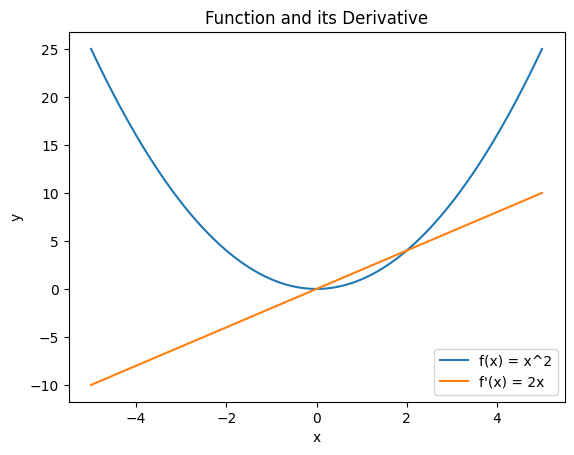

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function and its derivative
def f(x):
    return x ** 2

def f_prime(x):
    return 2 * x

# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate y values for the function and its derivative
y = f(x)
y_prime = f_prime(x)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the function and its derivative using the axes object
ax.plot(x, y, label="f(x) = x^2")
ax.plot(x, y_prime, label="f'(x) = 2x")

# Add a legend and titles
ax.legend()
ax.set_title("Function and its Derivative")
ax.set_xlabel("x")
ax.set_ylabel("y")

# Display the plot
plt.show()


In [17]:
t = torch.linspace(-5,5,1000)

In [18]:
def vis_act_fn(act_fn, ax, x):
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ax.plot(x,y, label="act_fn")
    ax.plot(x,y_grads, label="grad")
    ax.legend()
    ax.set_title(act_fn.name)
    ax.set_ylim(-1.5, x.max())

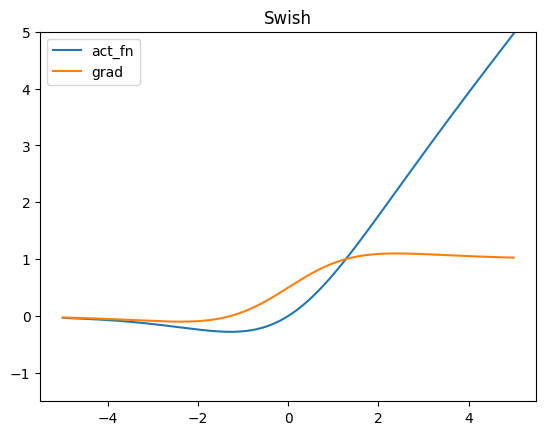

In [19]:
fig, ax = plt.subplots()
vis_act_fn(Swish(), ax, t)

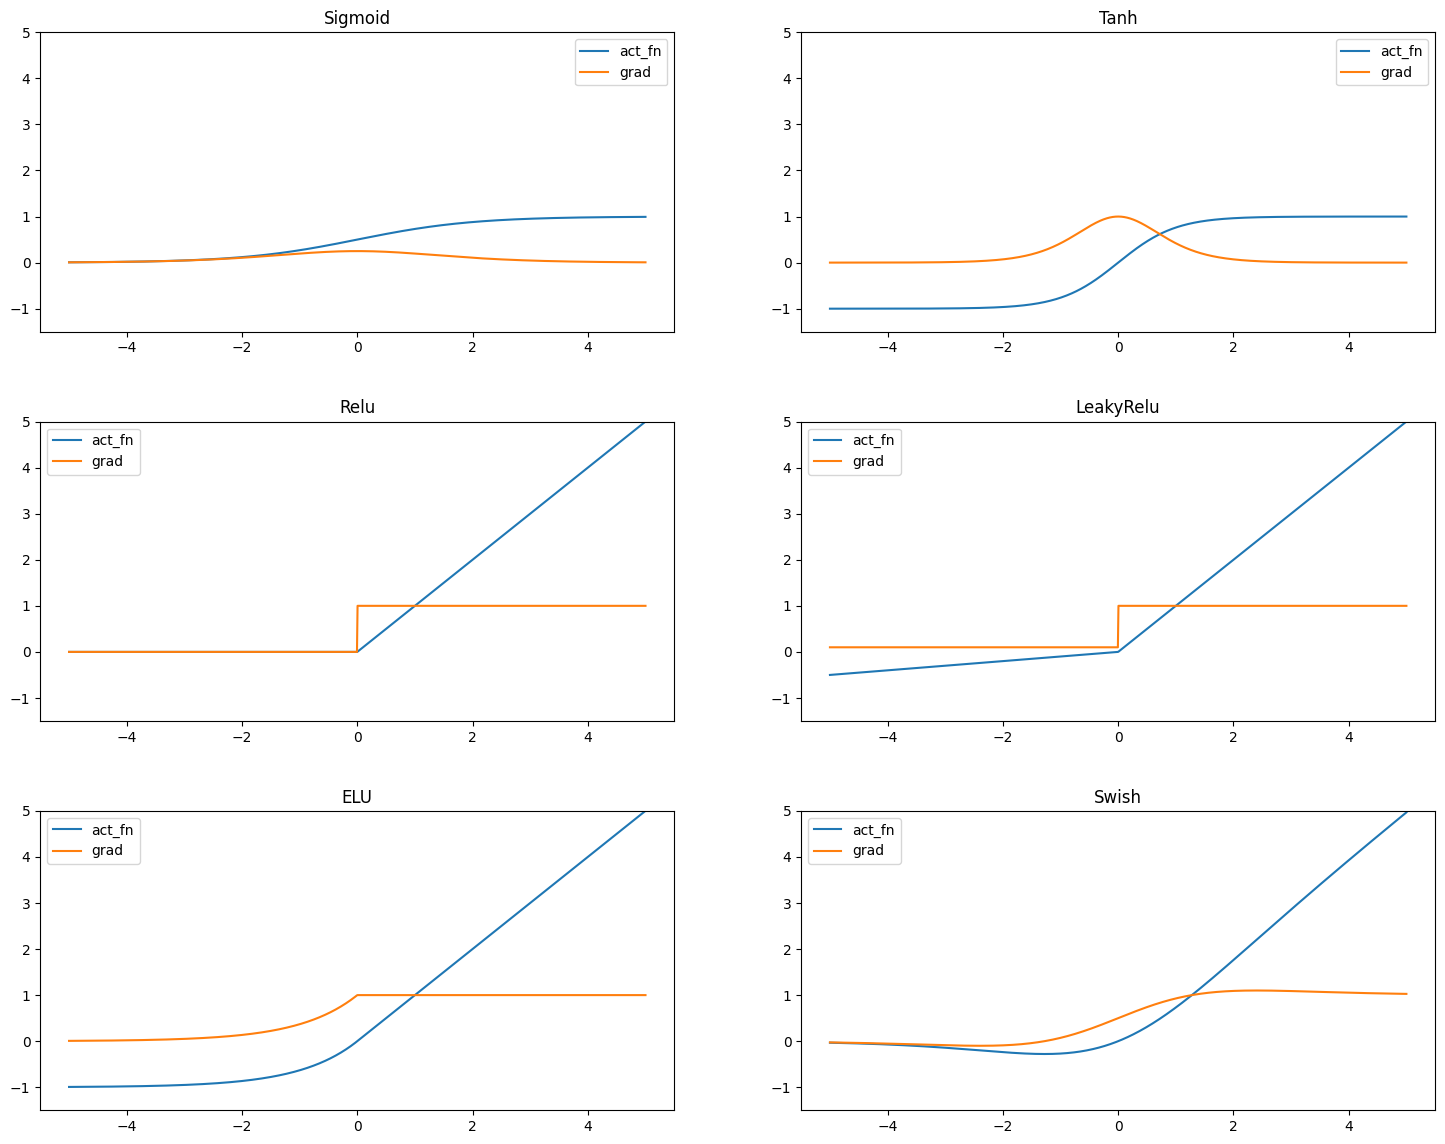

In [20]:
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
# act_fns 
fig, ax = plt.subplots(3, 2, figsize=(18, 14))
ax
for idx, act_fn in enumerate(act_fns):
    ax_idx = divmod(idx,2)
    vis_act_fn(act_fn, ax[ax_idx], t) 
fig.subplots_adjust(hspace=0.3)
plt.show()

Model creation


In [21]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layers_size = [input_size] + hidden_sizes
        for layer_idx in range(1, len(layers_size)):
            layers += [nn.Linear(layers_size[layer_idx-1], layers_size[layer_idx]), act_fn]
        layers += [nn.Linear(layers_size[-1], num_classes)] 
        self.layers = nn.Sequential(*layers)
        self.config = {'act_fn':act_fn.config, 'input_size':input_size, 'num_classes':num_classes, 'hidden_sizes':hidden_sizes}
        print(self.config)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        # x = torch.einsum('ijk->i', x)
        # print(x)
        out = self.layers(x)
        return out

In [22]:
bn = BaseNetwork(LeakyRelu(), 768, 10, [256, 512, 768, 256])
bn.layers

{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 768, 'num_classes': 10, 'hidden_sizes': [256, 512, 768, 256]}


Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): LeakyRelu()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyRelu()
  (4): Linear(in_features=512, out_features=768, bias=True)
  (5): LeakyRelu()
  (6): Linear(in_features=768, out_features=256, bias=True)
  (7): LeakyRelu()
  (8): Linear(in_features=256, out_features=10, bias=True)
)

In [23]:
x = torch.randint(1,5, (768,5,6), dtype=torch.float32)
x.dtype
# x
# y = x.view(x.size(0), -1)
# x.shape,y.shape

torch.float32

In [24]:
# bn(x)

In [25]:
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_dataloader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
test_dataloader = data.DataLoader(test_set, batch_size=1024, shuffle=True, drop_last=False)
val_dataloader = data.DataLoader(val_set, batch_size=1024, shuffle=True, drop_last=False)


In [26]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(49, 10, 10)

In [27]:
train_set[0][1]

0

In [28]:
exp_img = [train_set[i][0] for i in range(16)]
torch.stack(exp_img, dim=0).shape

torch.Size([16, 1, 28, 28])

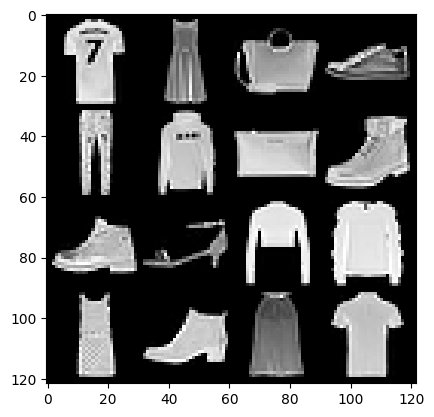

In [29]:
img_grid = torchvision.utils.make_grid(torch.stack(exp_img, dim=0), nrow=4, normalize=True).permute(1,2,0)
plt.imshow(img_grid)

In [30]:
import json
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name+".config")
def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name+".tar")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    # print(config_file, model_file)
    assert os.path.isfile(config_file), f"The file does not exist"
    assert os.path.isfile(model_file), f"The file does not exist"
    with open(config_file, "r") as file:
        config_dict = json.load(file)
        print(config_dict)
    if net is None:
        # def __init__(self, act_fn, input_size, num_classes, hidden_sizes):
        act_fn = config_dict.pop('act_fn').pop('name').lower()
        print(act_fn, act_fn_by_name[act_fn], config_dict)
        net = BaseNetwork(act_fn_by_name[act_fn](), **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, 'w') as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)    

In [31]:
MODEL_PATH = "../saved_models/T3"
MODEL_NAME = "FashionMNIST_relu"
device

device(type='cuda')

In [32]:
load_model(MODEL_PATH, MODEL_NAME)

{'act_fn': {'name': 'ReLU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
relu <class '__main__.Relu'> {'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


In [33]:
import torch.nn.functional as F
from icecream import ic 
import seaborn as sns
def visualize_gradients(net, color="C0"):
    net.eval()
    small_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    print(imgs.shape, labels.shape)
    net.to(device)
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    # import ipdb;  ipdb.set_trace()
    loss.backward() 
    # print(net.named_parameters())
    # for names, params in net.named_parameters():
    #     print(names, params.shape)
    #     print(params.grad.data.view(-1).cpu().clone().numpy())
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    # grads1 = {name: params for name, params in net.named_parameters() if "weight" in name}
    # print(grads)
    # print(grads1)
    net.zero_grad()

    columns = len(grads)
    ic(columns)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        ic(key)
        key_ax = ax[fig_index%columns]
        ic(key, key_ax)
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
        

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >


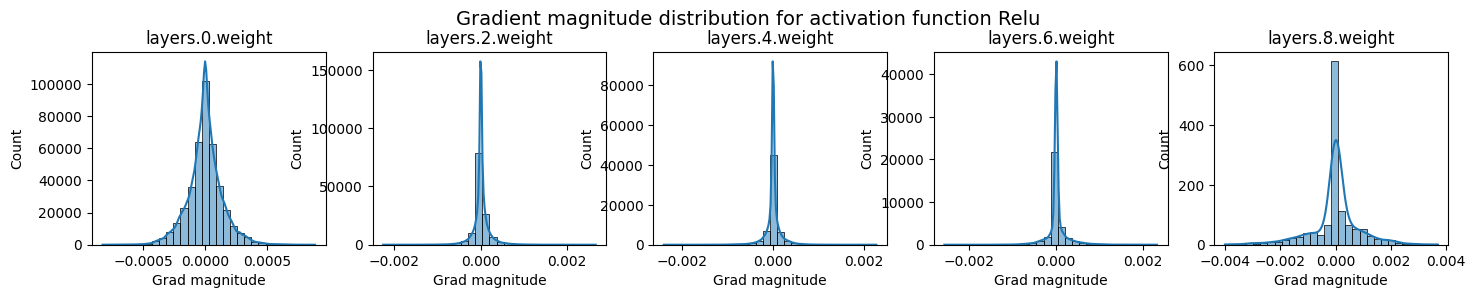

In [34]:
net = BaseNetwork(Relu())
visualize_gradients(net)        

ic| act_name: 'sigmoid', act_fn: <class '__main__.Sigmoid'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'tanh', act_fn: <class '__main__.Tanh'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'relu', act_fn: <class '__main__.Relu'>
ic| columns: 5


{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >
ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'leakyrelu', act_fn: <class '__main__.LeakyRelu'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'elu', act_fn: <class '__main__.ELU'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >
ic| act_name: 'swish', act_fn: <class '__main__.Swish'>
ic| columns: 5
ic| key: 'layers.0.weight'
ic| key: 'layers.0.weight', key_ax: <Axes: >


{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}
torch.Size([256, 1, 28, 28]) torch.Size([256])


ic| key: 'layers.2.weight'
ic| key: 'layers.2.weight', key_ax: <Axes: >
ic| key: 'layers.4.weight'
ic| key: 'layers.4.weight', key_ax: <Axes: >
ic| key: 'layers.6.weight'
ic| key: 'layers.6.weight', key_ax: <Axes: >
ic| key: 'layers.8.weight'
ic| key: 'layers.8.weight', key_ax: <Axes: >


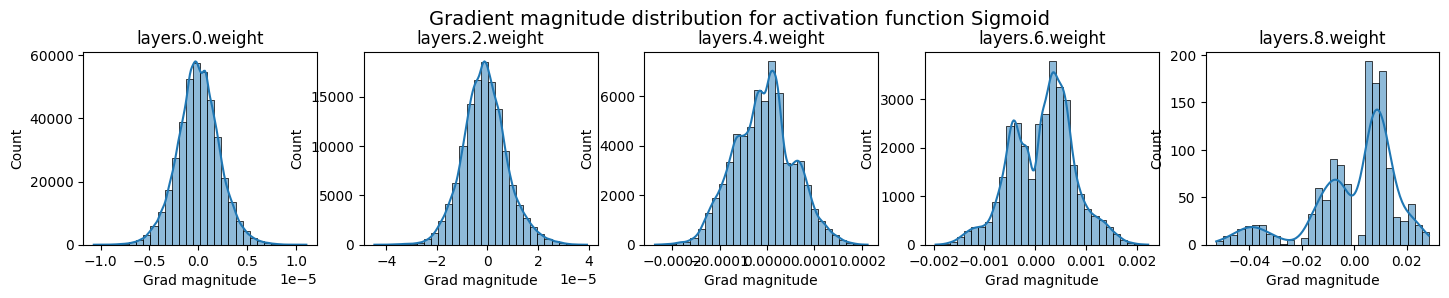

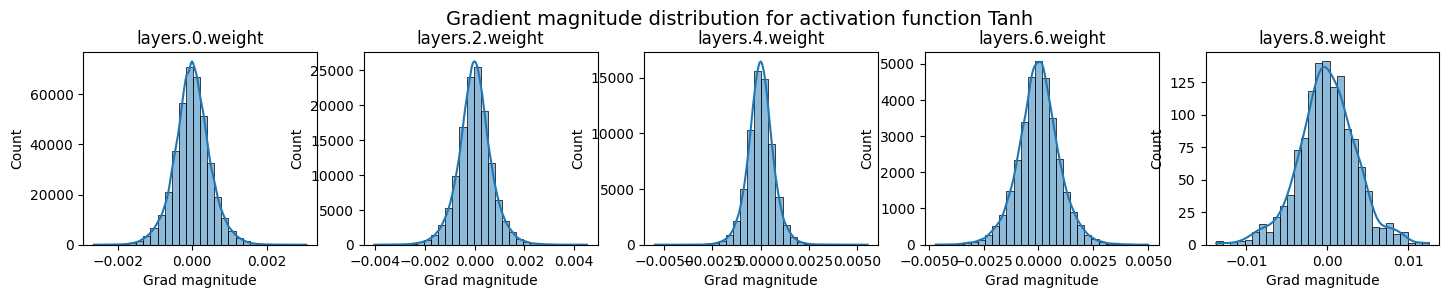

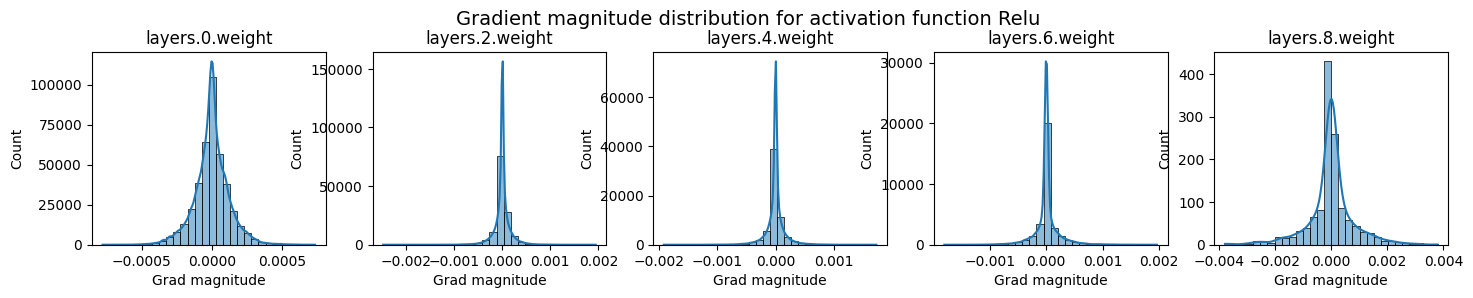

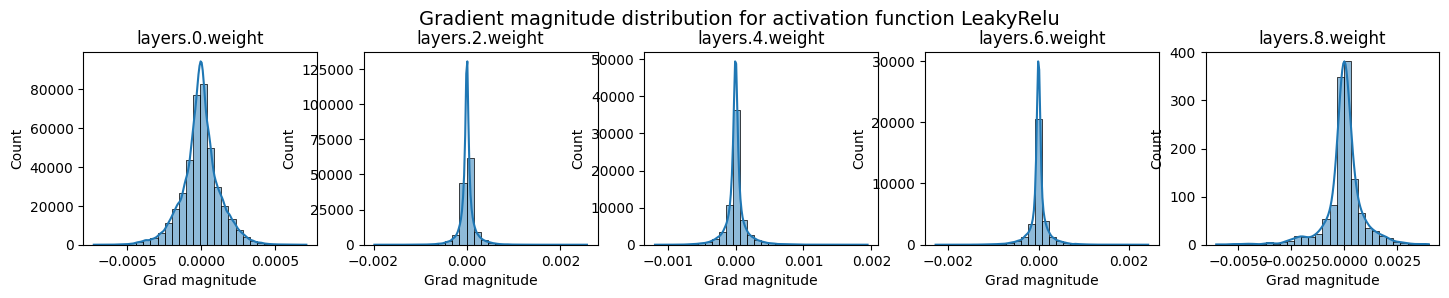

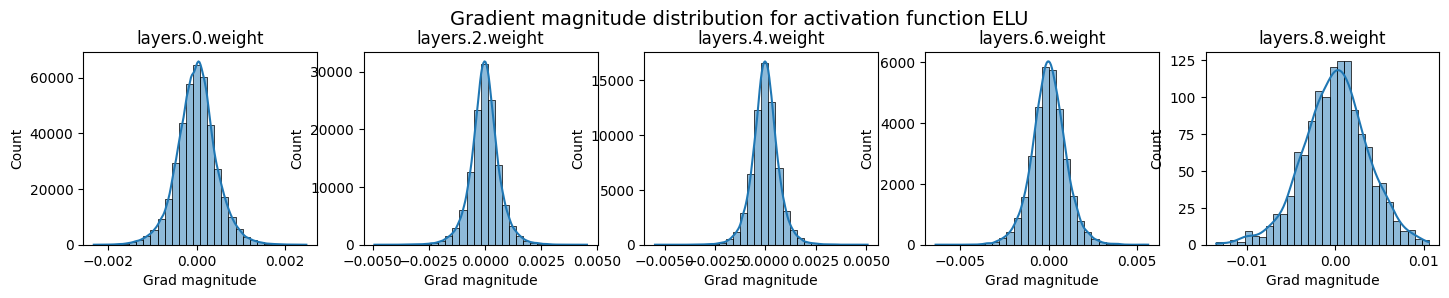

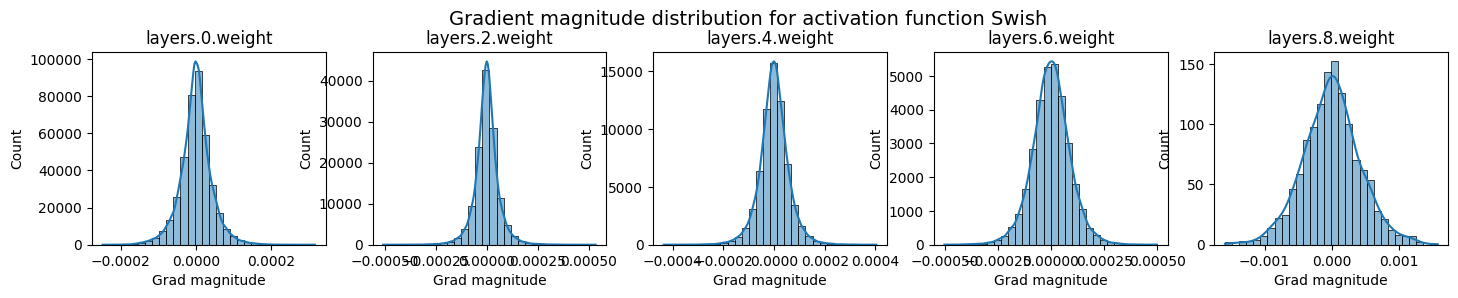

In [35]:
for act_name, act_fn in act_fn_by_name.items():
    ic(act_name, act_fn)
    net = BaseNetwork(act_fn())
    visualize_gradients(net)

In [54]:

MODEL_PATH = "../saved_models/T3"
MODEL_NAME = "FashionMNIST_relu"
CHECKPOINT_PATH


'../saved_models/T3'

TRAINING

In [120]:
from tqdm import tqdm
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name=model_name))
    ic(file_exists)
    if file_exists and not overwrite:
        print(f'{model_name}.tar exists, skipping the training.....')
    else:
        if file_exists:
                print(f'{model_name}.tar exists, will be overwritten.')
        print(f'{model_name} is setting up for training.....')
        # defining optimizer, loss, and data loader
        optim = torch.optim.SGD(net.parameters(), lr = 1e-2, momentum=0.9)
        loss_module = nn.CrossEntropyLoss()
        # tbc
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
        best_val_epoch = -1
        val_scores = []
        for epoch in range(max_epochs):
            net.train()
            true_preds, count = 0, 0
            for image, labels in tqdm(train_loader_local, desc=f'epoch: {epoch+1}', leave=False):
                # ic(".....")
                image, labels = image.to(device), labels.to(device)
                optim.zero_grad()
                preds = net(image)
                loss = loss_module(preds, labels)
                loss.backward()
                optim.step()
                # ic(preds.shape)
                # ic(labels.shape)
                # ic(preds.argmax(dim=-1).shape)
                true_preds += (preds.argmax(dim=-1)==labels).sum()
                count += labels.shape[0]
            train_acc = true_preds/count
            ic(train_acc)

            # validation
            val_acc = test_model(net, val_dataloader)
            val_scores.append(val_acc)
            if len(val_scores)==1 or val_acc > val_scores[best_val_epoch]:
                print((f"new best performance with val_acc: {val_acc*100.0:4.2f}% ").center(50, "=")+"\n")
                print("saving checkpoint.............")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch=epoch
            elif (best_val_epoch <= epoch-patience):
                print(f'Early stopping dure to no improvements over {patience} epochs....best_epoch: {best_val_epoch}, current epoch: {epoch}')
                break
                # Plot a curve of the validation accuracy
            
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_dataloader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
                

In [121]:
def test_model(net, data_loader):
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in tqdm(data_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs)
            true_preds+= (preds.argmax(dim=-1)==labels).sum()
            count += labels.shape[0]
    test_acc = true_preds/count
    return test_acc.cpu()



Training BaseNetwork with sigmoid activation...
{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| file_exists: True


FashionMNIST_sigmoid.tar exists, will be overwritten.
FashionMNIST_sigmoid is setting up for training.....


ic                                                         | train_acc: tensor(0.0996, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


====new best performance with val_acc: 10.13% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.0971, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 10.18% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.0989, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                         | train_acc: tensor(0.1020, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                         | train_acc: tensor(0.1007, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                         | train_acc: tensor(0.1021, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
ic                                                         | train_acc: tensor(0.0994, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                         | train_acc: tensor(0.1025, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                         | train_acc: tensor(0.1005, d

====new best performance with val_acc: 10.64% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.1039, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]
ic                                                          | train_acc: tensor(0.1040, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.1046, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.1035, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.1038, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 17.49% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.1061, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.1052, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.1050, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.1179, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.1248, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


====new best performance with val_acc: 18.01% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.1501, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 28.47% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.2018, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.2554, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 35.44% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.3815, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 39.38% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.5290, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 57.94% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.5928, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 61.03% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.6273, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 63.80% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.6474, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 65.57% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.6648, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 68.48% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.6860, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 70.33% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7047, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]
ic                                                          | train_acc: tensor(0.7167, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


====new best performance with val_acc: 72.14% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7324, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 73.19% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7394, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 74.23% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7466, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


====new best performance with val_acc: 75.06% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7508, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


====new best performance with val_acc: 75.68% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7586, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


====new best performance with val_acc: 76.10% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7646, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


====new best performance with val_acc: 76.79% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7692, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 76.87% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7746, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


====new best performance with val_acc: 77.59% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7787, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 78.16% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7816, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


====new best performance with val_acc: 78.23% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7851, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 78.84% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7897, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 79.31% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.7918, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.7963, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.7991, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 79.90% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8025, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.8058, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 80.28% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8072, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.8096, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 80.77% ====

saving checkpoint.............


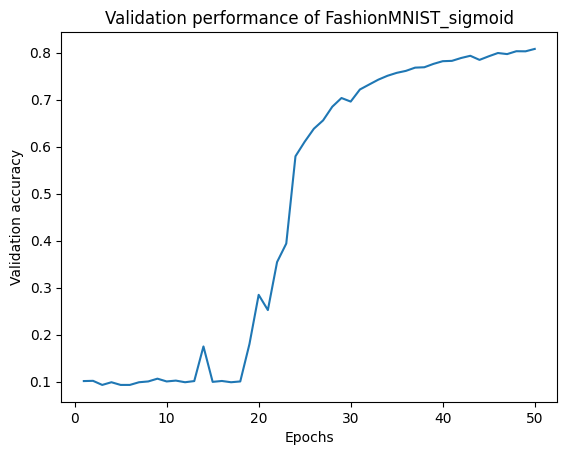

{'act_fn': {'name': 'Sigmoid'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


============= Test accuracy: 80.01% ==============

Training BaseNetwork with tanh activation...
{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| file_exists: True


FashionMNIST_tanh.tar exists, will be overwritten.
FashionMNIST_tanh is setting up for training.....


ic                                                         | train_acc: tensor(0.6632, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


====new best performance with val_acc: 79.60% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8135, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 83.00% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8399, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


====new best performance with val_acc: 84.40% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8518, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


====new best performance with val_acc: 85.65% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8569, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                         | train_acc: tensor(0.8645, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 86.06% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8685, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 86.59% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8735, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


====new best performance with val_acc: 87.32% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8768, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.71it/s]
ic                                                          | train_acc: tensor(0.8805, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.8823, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.67it/s]
ic                                                          | train_acc: tensor(0.8859, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 88.05% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8888, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.8894, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


====new best performance with val_acc: 88.30% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8944, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.8968, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]
ic                                                          | train_acc: tensor(0.8978, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.12it/s]
ic                                                          | train_acc: tensor(0.8990, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


====new best performance with val_acc: 88.58% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9037, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.72it/s]
ic                                                          | train_acc: tensor(0.9051, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.9058, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.9078, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9106, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9102, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


====new best performance with val_acc: 88.70% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9131, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.9144, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 88.89% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9160, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.9190, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
ic                                                          | train_acc: tensor(0.9154, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.9213, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 88.90% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9234, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9244, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


====new best performance with val_acc: 89.22% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9274, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.68it/s]
ic                                                          | train_acc: tensor(0.9279, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
ic                                                          | train_acc: tensor(0.9285, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.9281, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]
ic                                                          | train_acc: tensor(0.9318, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.9317, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


====new best performance with val_acc: 89.25% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9327, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.63it/s]


====new best performance with val_acc: 89.38% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9366, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.9365, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
ic                                                          | train_acc: tensor(0.9391, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.9397, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
ic                                                          | train_acc: tensor(0.9398, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]
ic                                                          | train_acc: tensor(0.9413, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 38, current epoch: 45


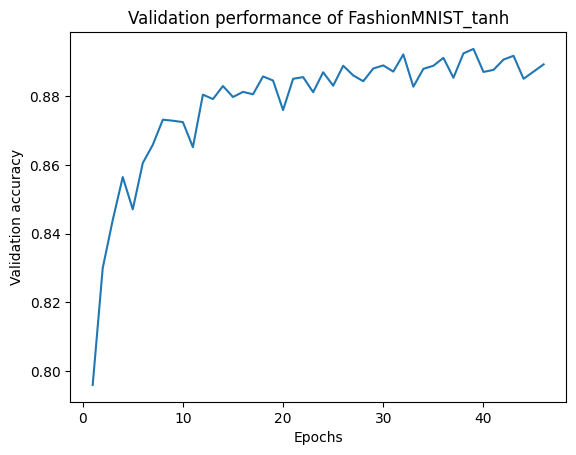

{'act_fn': {'name': 'Tanh'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


============= Test accuracy: 88.34% ==============

Training BaseNetwork with relu activation...
{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| file_exists: True


FashionMNIST_relu.tar exists, will be overwritten.
FashionMNIST_relu is setting up for training.....


ic                                                         | train_acc: tensor(0.4882, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


====new best performance with val_acc: 70.93% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7866, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 81.86% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8275, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


====new best performance with val_acc: 84.02% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8486, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 86.01% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8609, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.61it/s]
ic                                                         | train_acc: tensor(0.8702, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 86.50% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8756, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


====new best performance with val_acc: 86.52% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8816, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


====new best performance with val_acc: 87.67% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8860, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


====new best performance with val_acc: 87.72% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8915, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


====new best performance with val_acc: 87.95% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8946, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.63it/s]
ic                                                          | train_acc: tensor(0.8981, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


====new best performance with val_acc: 88.63% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9015, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.71it/s]
ic                                                          | train_acc: tensor(0.9064, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


====new best performance with val_acc: 88.91% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9095, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.69it/s]
ic                                                          | train_acc: tensor(0.9118, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.72it/s]
ic                                                          | train_acc: tensor(0.9135, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


====new best performance with val_acc: 89.29% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9188, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.05it/s]
ic                                                          | train_acc: tensor(0.9218, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.72it/s]
ic                                                          | train_acc: tensor(0.9245, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.65it/s]
ic                                                          | train_acc: tensor(0.9272, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9307, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
ic                                                          | train_acc: tensor(0.9306, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]
ic                                                          | train_acc: tensor(0.

====new best performance with val_acc: 89.51% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9360, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9366, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


====new best performance with val_acc: 89.68% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9363, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.67it/s]
ic                                                          | train_acc: tensor(0.9434, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.68it/s]
ic                                                          | train_acc: tensor(0.9378, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.53it/s]
ic                                                          | train_acc: tensor(0.9450, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.9486, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.68it/s]
ic                                                          | train_acc: tensor(0.9497, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 25, current epoch: 32


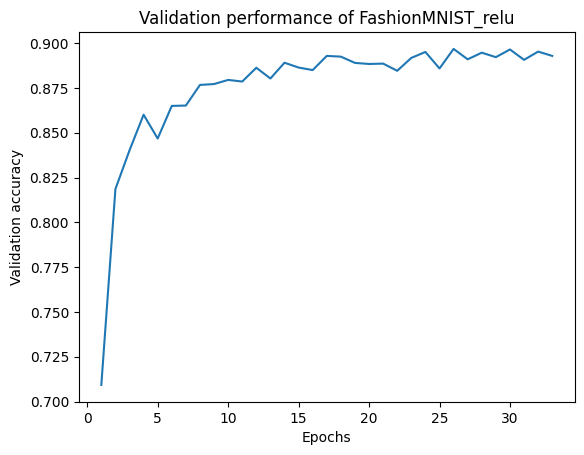

{'act_fn': {'name': 'Relu'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.54it/s]


============= Test accuracy: 88.69% ==============

Training BaseNetwork with leakyrelu activation...
{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| file_exists: True


FashionMNIST_leakyrelu.tar exists, will be overwritten.
FashionMNIST_leakyrelu is setting up for training.....


ic                                                         | train_acc: tensor(0.5025, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 71.87% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7899, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


====new best performance with val_acc: 82.12% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8274, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


====new best performance with val_acc: 83.93% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8472, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


====new best performance with val_acc: 85.80% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8588, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.72it/s]
ic                                                         | train_acc: tensor(0.8668, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 86.44% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8722, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                         | train_acc: tensor(0.8788, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


====new best performance with val_acc: 87.47% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8823, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


====new best performance with val_acc: 87.66% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8877, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.8903, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
ic                                                          | train_acc: tensor(0.8952, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 88.27% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8976, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.69it/s]
ic                                                          | train_acc: tensor(0.9008, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


====new best performance with val_acc: 88.73% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9054, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
ic                                                          | train_acc: tensor(0.9066, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]
ic                                                          | train_acc: tensor(0.9094, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 89.00% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9121, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]
ic                                                          | train_acc: tensor(0.9171, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]
ic                                                          | train_acc: tensor(0.9186, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.71it/s]
ic                                                          | train_acc: tensor(0.9219, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]
ic                                                          | train_acc: tensor(0.9250, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
ic                                                          | train_acc: tensor(0.9230, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.

====new best performance with val_acc: 89.36% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9284, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.9302, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


====new best performance with val_acc: 89.52% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9309, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9364, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.9289, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9384, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.9421, device='cuda:0')
100%|██████████| 10/10 [00:02<00:00,  5.00it/s]
ic                                                          | train_acc: tensor(0.9427, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 89.67% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9454, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.64it/s]
ic                                                          | train_acc: tensor(0.9463, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9475, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.65it/s]
ic                                                          | train_acc: tensor(0.9445, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


====new best performance with val_acc: 89.82% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9466, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.64it/s]
ic                                                          | train_acc: tensor(0.9475, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.9511, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.9531, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.9554, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9523, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 35, current epoch: 42


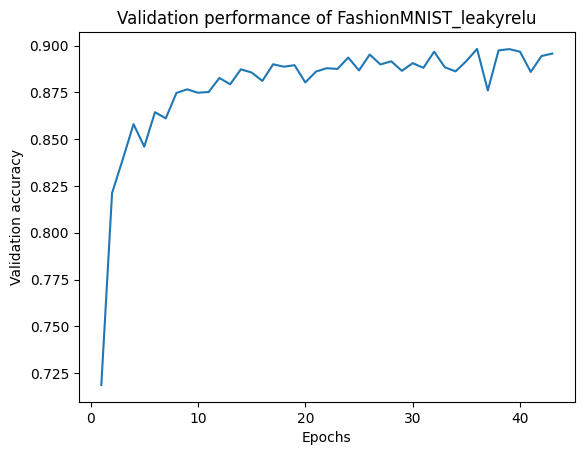

{'act_fn': {'name': 'LeakyRelu', 'alpha': 0.1}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


============= Test accuracy: 88.72% ==============

Training BaseNetwork with elu activation...
{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| file_exists: True


FashionMNIST_elu.tar exists, will be overwritten.
FashionMNIST_elu is setting up for training.....


ic                                                         | train_acc: tensor(0.6653, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


====new best performance with val_acc: 79.17% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8130, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 82.72% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8377, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


====new best performance with val_acc: 84.54% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8495, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


====new best performance with val_acc: 85.73% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8562, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                         | train_acc: tensor(0.8620, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 85.88% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8657, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


====new best performance with val_acc: 86.32% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8706, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 86.64% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8717, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


====new best performance with val_acc: 86.83% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8762, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]
ic                                                          | train_acc: tensor(0.8767, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


====new best performance with val_acc: 86.93% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8823, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 87.66% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8854, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.76it/s]
ic                                                          | train_acc: tensor(0.8852, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 88.03% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8889, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.8914, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.8930, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.8942, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 88.23% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8967, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.8999, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.8997, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
ic                                                          | train_acc: tensor(0.9013, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.69it/s]
ic                                                          | train_acc: tensor(0.9045, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]
ic                                                          | train_acc: tensor(0.9029, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


====new best performance with val_acc: 88.79% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9072, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.9084, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.9058, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
ic                                                          | train_acc: tensor(0.9108, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.69it/s]
ic                                                          | train_acc: tensor(0.9104, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]
ic                                                          | train_acc: tensor(0.9121, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 23, current epoch: 30


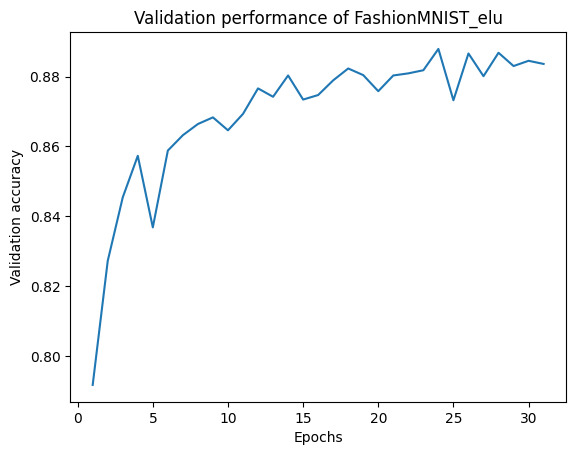

{'act_fn': {'name': 'ELU'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


============= Test accuracy: 87.74% ==============

Training BaseNetwork with swish activation...
{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


ic| file_exists: True


FashionMNIST_swish.tar exists, will be overwritten.
FashionMNIST_swish is setting up for training.....


ic                                                         | train_acc: tensor(0.2745, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


====new best performance with val_acc: 30.95% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.6450, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


====new best performance with val_acc: 75.75% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.7875, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


====new best performance with val_acc: 81.27% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8247, device='cuda:0')
100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


====new best performance with val_acc: 84.14% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8381, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                         | train_acc: tensor(0.8486, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 84.89% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8543, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


====new best performance with val_acc: 85.27% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8604, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 86.24% ====

saving checkpoint.............


ic                                                         | train_acc: tensor(0.8638, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]


====new best performance with val_acc: 86.35% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8688, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
ic                                                          | train_acc: tensor(0.8710, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 86.71% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8741, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


====new best performance with val_acc: 87.50% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8773, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.8798, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


====new best performance with val_acc: 87.52% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8822, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.86it/s]
ic                                                          | train_acc: tensor(0.8837, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.8867, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


====new best performance with val_acc: 87.82% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8894, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


====new best performance with val_acc: 87.92% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8909, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.8933, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.82it/s]
ic                                                          | train_acc: tensor(0.8946, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


====new best performance with val_acc: 88.02% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.8972, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]
ic                                                          | train_acc: tensor(0.8999, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


====new best performance with val_acc: 88.61% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9001, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


====new best performance with val_acc: 88.69% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9016, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]
ic                                                          | train_acc: tensor(0.9047, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.79it/s]
ic                                                          | train_acc: tensor(0.9032, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.74it/s]
ic                                                          | train_acc: tensor(0.9059, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
ic                                                          | train_acc: tensor(0.9074, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.70it/s]
ic                                                          | train_acc: tensor(0.9094, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


====new best performance with val_acc: 88.91% ====

saving checkpoint.............


ic                                                          | train_acc: tensor(0.9096, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
ic                                                          | train_acc: tensor(0.9146, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.69it/s]
ic                                                          | train_acc: tensor(0.9137, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.75it/s]
ic                                                          | train_acc: tensor(0.9161, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.85it/s]
ic                                                          | train_acc: tensor(0.9149, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
ic                                                          | train_acc: tensor(0.9152, device='cuda:0')
100%|██████████| 10/10 [00:01<00:00,  5.78it/s]
ic                                                          | train_acc: tensor(0.

Early stopping dure to no improvements over 7 epochs....best_epoch: 29, current epoch: 36


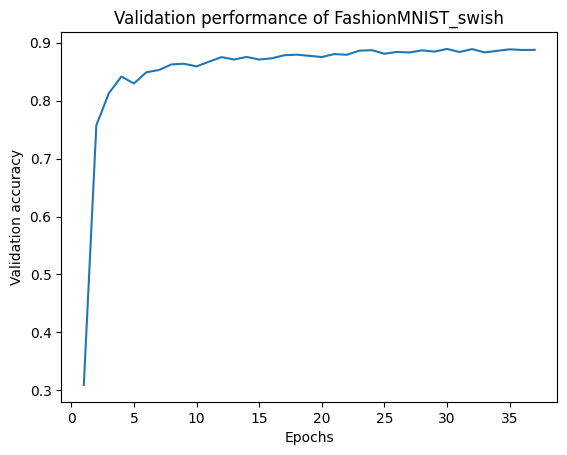

{'act_fn': {'name': 'Swish'}, 'input_size': 784, 'num_classes': 10, 'hidden_sizes': [512, 256, 256, 128]}


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


============= Test accuracy: 88.07% ==============



In [122]:
for act_name, act_fn in act_fn_by_name.items():
    print(f"Training BaseNetwork with {act_name} activation...")
    set_seed(42)
    net = BaseNetwork(act_fn()).to(device)
    train_model(net, f'FashionMNIST_{act_name}', overwrite=True)
    # test_model(net, val_dataloader)
    # break
